# CIFAR examples

This code runs CIFAR10 and CIFAR100. To switch between these two datasets, update the `dataset` field in `train_config.yaml` and the `data_path` field in `audit.yaml` accordingly.


In [1]:
# !pip install opacus

In [2]:
import os
import sys
import yaml
 
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)


In [3]:

from utils.cifar_data_preparation import get_cifar_dataloader
from utils.cifar_dpsgd_model_preparation import ResNet18, create_trained_dpsgdmodel_and_metadata


# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_loader, test_loader = get_cifar_dataloader(path, train_config)

Files already downloaded and verified
Files already downloaded and verified



## Noise Multiplier Configuration for Privacy Analysis

In this code block, we configure the parameters necessary for calculating the noise multiplier using the **Ocapi** library, which we used for differential privacy analysis. 

- **`target_epsilon`**: The desired epsilon value.
- **`target_delta`**: The delta value indicating the risk of privacy loss.
- **`sample_rate`**: The rate at which data points are used in training.
- **`epochs`**: The number of training epochs for the model.
- **`epsilon_tolerance`**: A small margin for the epsilon value,
- **`accountant`**: Specifies the method of tracking privacy loss, with "prv" referring to the Privacy Accountant for DPSGD.
- **`eps_error`**: The allowable error in epsilon calculations
- **`max_grad_norm`**: A limit on the gradient norm to ensure the gradients do not explode during training.

The most common hyperparameters to tune are `target_epsilon`, `sample_rate`, `noise_multiplier`, and `max_grad_norm`. These parameters should be inputed by the user based on thier need for balancing privacy and utility.


In [5]:
target_model_dir = "./target_dpsgd"
delta = 1e-5
target_epsilon = 3.5
sample_rate = 1/len(train_loader) # already incorporates batchsize
    
noise_multiplier_dict = {
    "target_epsilon": target_epsilon,
    "target_delta": delta,
    "sample_rate": sample_rate,
    "epochs": 21,
    "epsilon_tolerance": 0.01,
    "accountant": "prv",
    "eps_error": 0.01,
    "max_grad_norm": 1,
}


In [6]:
# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Set the model
model = ResNet18(num_classes = num_classes)

# Import ModuleValidator from opacus to ensure privacy compatability of the model
from opacus.validators import ModuleValidator

# Validate the model, extract the errors and print the last 5
errors = ModuleValidator.validate(model, strict=False)
print(errors[-5:])

# Error for ResNet18:
#       Module 'ResNet18' has the following privacy violations:
#       BatchNorm layers are not supported because they compute the mean and variance across the batch, 
#           creating a dependency between samples in a batch, a privacy violation.

[ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normalized value depend on its peers in a batch, ie the same sample x will get normalized to a different value depending on who else is on its batch. Privacy-wise, this means that we would have to put a privacy mechanism there too. While it can in principle be done, there are now multiple normalization layers that do not have this issue: LayerNorm, InstanceNorm and their generalization GroupNorm are all privacy-safe since they don't have this property.We offer utilities to automatically replace BatchNorms to GroupNorms and we will release pretrained models to help transition, such as GN-ResNet ie a ResNet using GroupNorm, pretrained on ImageNet"), ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normalized value depend on its peers in a batch, ie the s

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Use ModuleValidator.fix to fix the models privacy violations
model = ModuleValidator.fix(model)

# Validate the model again, check for privacy violations
errors = ModuleValidator.validate(model, strict=False)

# Should print empty list
print(errors[-5:])

train_acc, train_loss, test_acc, test_loss, model, privacy_engine = create_trained_dpsgdmodel_and_metadata(model, 
                                                                               train_loader, 
                                                                               test_loader, 
                                                                               train_config,
                                                                               noise_multiplier_dict,
                                                                               target_model_dir = target_model_dir
                                                                               )

[]


/opt/conda/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward c

[]


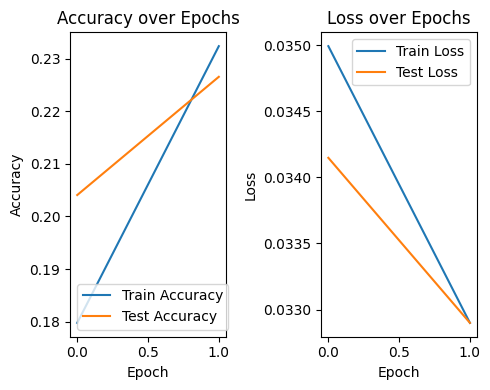

In [8]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from cifar_handler import CifarInputHandler
from cifar_handler_dpsgd import CifarInputHandlerDPsgd

from leakpro import LeakPro

# # Read the config file
# config_path = "audit_dpsgd.yaml"

# # Prepare leakpro object
# leakpro = LeakPro(CifarInputHandler, config_path)

# Read the DPsgd config file and prepare LeakPro object for DPsgd
config_path = "audit_dpsgd.yaml"
leakpro = LeakPro(CifarInputHandlerDPsgd, config_path)

# Run the audit 
mia_results_optuna = leakpro.run_audit(return_results=True, use_optuna=True)

03/18/2025 17:06:40:INFO:Target model blueprint created from ResNet18 in ./utils/cifar_dpsgd_model_preparation.py.
03/18/2025 17:06:40:INFO:Loaded target model metadata from ./target_dpsgd/model_metadata.pkl
03/18/2025 17:06:40:INFO:Loaded target model from ./target_dpsgd
03/18/2025 17:06:41:INFO:Loaded population dataset from ./data/cifar10.pkl
03/18/2025 17:06:41:INFO:Loaded population dataset from ./data/cifar10.pkl
03/18/2025 17:06:41:INFO:Image extension initialized.
03/18/2025 17:06:41:INFO:MIA attack factory loaded.
03/18/2025 17:06:41:INFO:Creating shadow model handler singleton
03/18/2025 17:06:41:INFO:Creating distillation model handler singleton


dpsgd exists in user_input_handler
dpsgd has been successfully attached to handler


03/18/2025 17:06:41:INFO:Configuring the RMIA attack
03/18/2025 17:06:41:INFO:User provided value for gamma, it won't be optimized by optuna.
03/18/2025 17:06:41:INFO:Added attack: rmia
03/18/2025 17:06:41:INFO:Shadow model handler singleton already exists, updating state
03/18/2025 17:06:41:INFO:Distillation model handler singleton already exists, updating state
03/18/2025 17:06:41:INFO:Added attack: lira
03/18/2025 17:06:41:INFO:Preparing attack: rmia
03/18/2025 17:06:41:INFO:Preparing shadow models for RMIA attack
03/18/2025 17:06:41:INFO:Check for 5 shadow models (dataset: 36000 points)
03/18/2025 17:06:41:INFO:Training shadow model 0 on 18048 points


Training shadow models with DP-SGD


TypeError: object of type 'ResNet18' has no len()

## Generate report

In [ ]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results_optuna:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# # Create the report by compiling the latex text
report_handler.create_report()